In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import flashbax as fbx
from flashbax.vault import Vault
from scipy.stats import norm
import matplotlib.pyplot as plt
import copy
import flashbax
from flashbax.buffers.trajectory_buffer import TrajectoryBufferState
import pickle
import seaborn as sns
from produce_count_info import create_count_information
from subsample_vault import subsample_smaller_vault

# Processing coverage information for a multi-agent dataset
We start with:
- values, reverse indexes (for rebuilding/reference back to original vault), counts

We want the following:
- a measure of diversity of actions per state
- a measure of diversity of observed rewards per state-action pair
- a measure of how much of the data is unique
- a measure of skewness - maybe an exponential like we see with that one law

Further, we want: 
- for each task, 
- - for each dataset - random, other
- - - SACo
- - - joint OACo
- - - per-agent OACo
- - Then, for each dataset notequalto random
- - - relative SACo
- - - relative OACo
- - - relative per-agent OACo

In [10]:
# set to False to reduce storage requirements
need_to_reconstruct=False
random_dataset_uid_pos = -2

In [3]:
rel_dir = "vaults/smac_v1"
vault_name = "5m_vs_6m"
vault_uids=["Good","Medium","Poor"]

for vault_uid in vault_uids:

    # make a smaller vault - it is easier for memory to handle
    new_vault_name = subsample_smaller_vault(rel_dir,vault_name,vault_uid,10000)

    # for each new vault, store count information at the new vault location
    # the need to reconstruct option allows us to store more or less information
    keys = create_count_information(rel_dir, new_vault_name, vault_uid, need_to_reconstruct)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m_10000.vlt/Good
9990
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m_10000.vlt/Good
agent_0
Number of unique: 13951
Most repeated pair's count: 3185
agent_1
Number of unique: 14364
Most repeated pair's count: 2794
agent_2
Number of unique: 14290
Most repeated pair's count: 2811
agent_3
Number of unique: 13680
Most repeated pair's count: 3477
agent_4
Number of unique: 13996
Most repeated pair's count: 3230
joint
Number of unique: 17083
Most repeated pair's count: 682
state
Number of unique: 17369
Most repeated pair's count: 33
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac

In [5]:
counts_over_datasets = {}

for uid in vault_uids:
    with open(rel_dir+"/"+new_vault_name+"/"+uid+"/count_info.pickle","rb") as f:
        counts_over_datasets[uid] = pickle.load(f)


In [11]:
all_ratios = []

for key in keys:
    num_unique = []
    # for the joint
    for i,uid in enumerate(vault_uids):
        if ~need_to_reconstruct:
            (counts, rewards) = counts_over_datasets[uid]
            num_unique.append(counts[key].shape[0])

    num_unique = np.array(num_unique)
    if random_dataset_uid_pos!=-2:
        num_unique = num_unique/num_unique[random_dataset_uid_pos]

    all_ratios.append(num_unique)


In [12]:
print("\t\t"+str(vault_uids))
for row, key in zip(all_ratios,keys):
    print(key+":   \t"+str(row))

		['Good', 'Medium', 'Poor']
agent_0:   	[13951 14213 14217]
agent_1:   	[14364 13907 11449]
agent_2:   	[14290 14221 12716]
agent_3:   	[13680 14164 12630]
agent_4:   	[13996 14293 12623]
joint:   	[17083 17810 17288]
state:   	[17369 18337 18049]


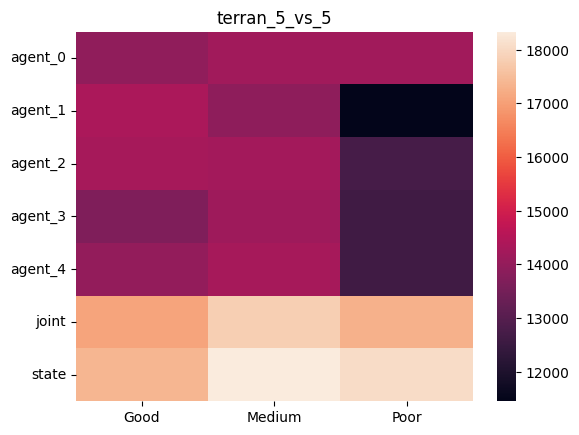

In [13]:
sns.heatmap(np.array(all_ratios),xticklabels=vault_uids,yticklabels=keys)
plt.title("terran_5_vs_5")
plt.savefig(rel_dir+"/"+new_vault_name+"/"+"OACo_heatmap.png")

In [ ]:
for key in keys:
    print("KEY: "+key)

    fig2,ax2 = plt.subplots(1,1,figsize=(6,6))

    fig, ax = plt.subplots(1,len(vault_uids), figsize=(len(vault_uids)*3,3))

    # for the joint
    for i,uid in enumerate(vault_uids):
        (counts, rewards) = counts_over_datasets[uid]
        vals2, counts2 = np.unique(counts[key],return_counts=True)

        ax2.scatter(np.log(vals2),np.log(counts2),label=uid)
        ax2.set_title(key)
        ax2.legend()
    plt.show()

KEY: agent_0


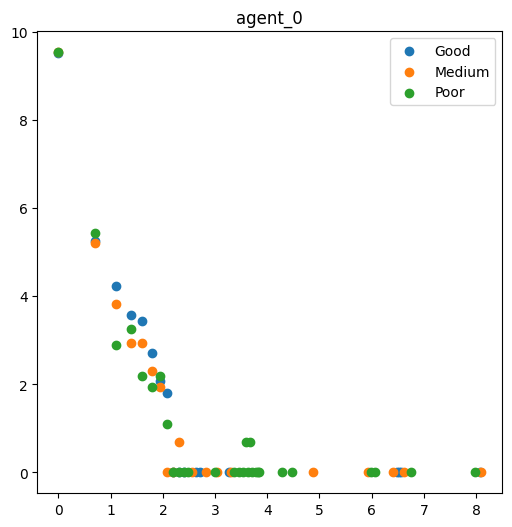

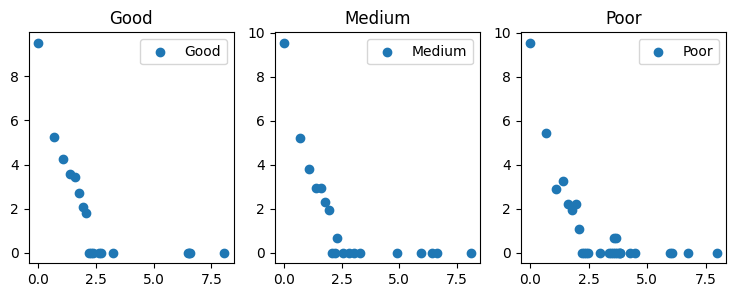

KEY: agent_1


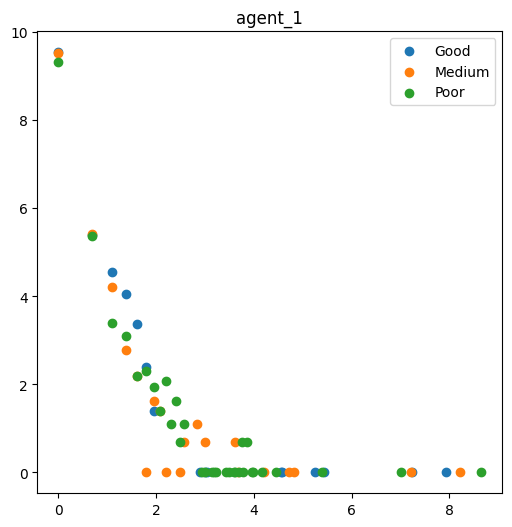

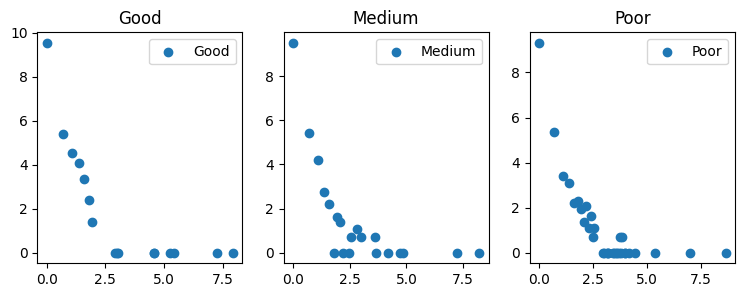

KEY: agent_2


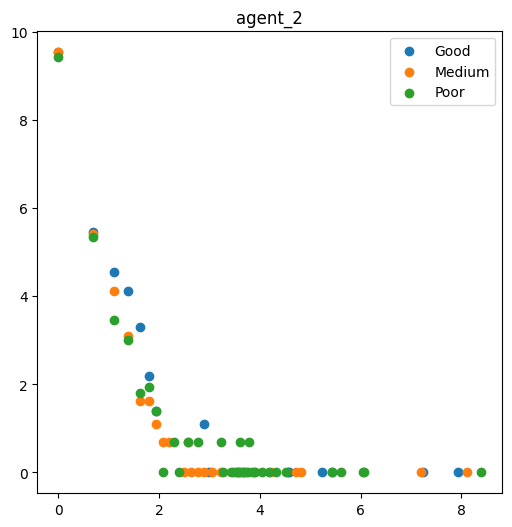

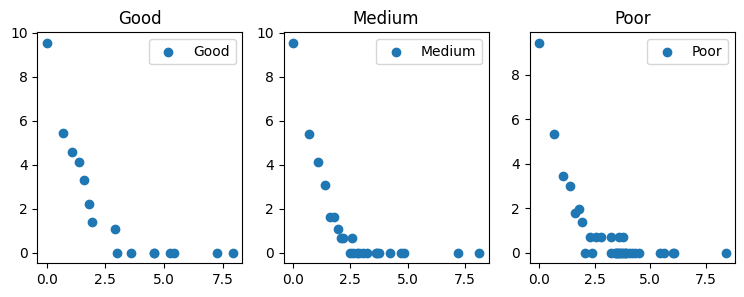

KEY: agent_3


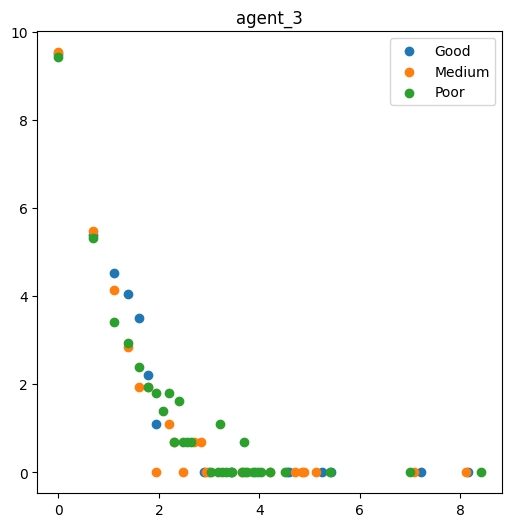

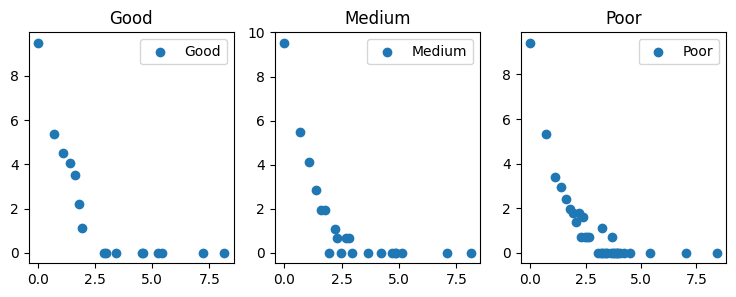

KEY: agent_4


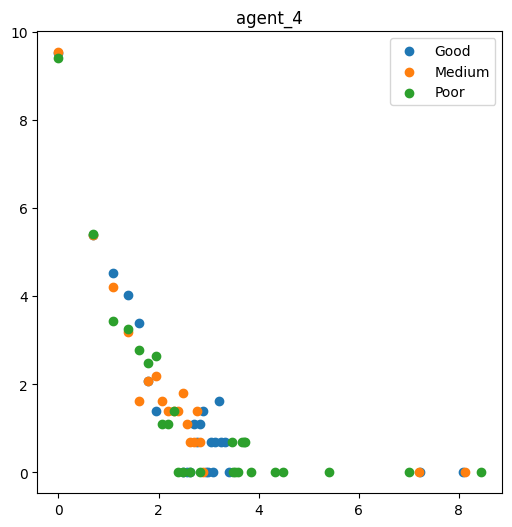

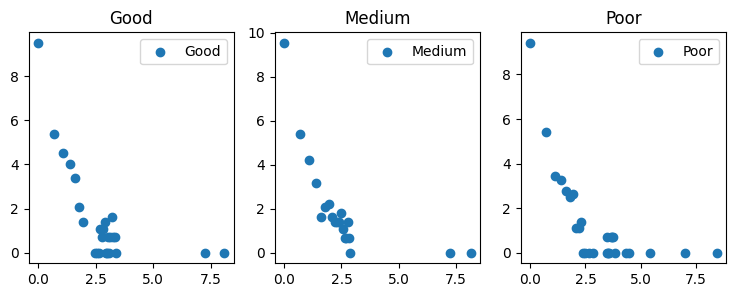

KEY: joint


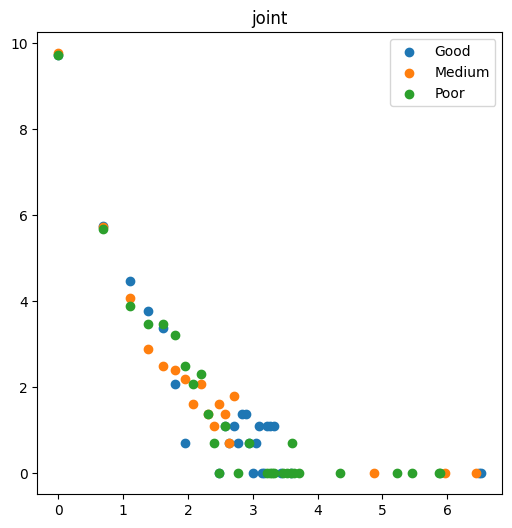

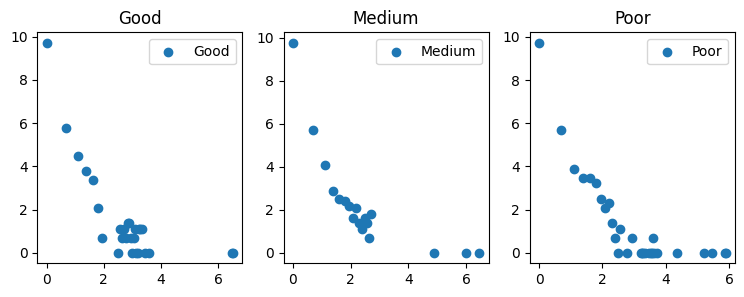

KEY: state


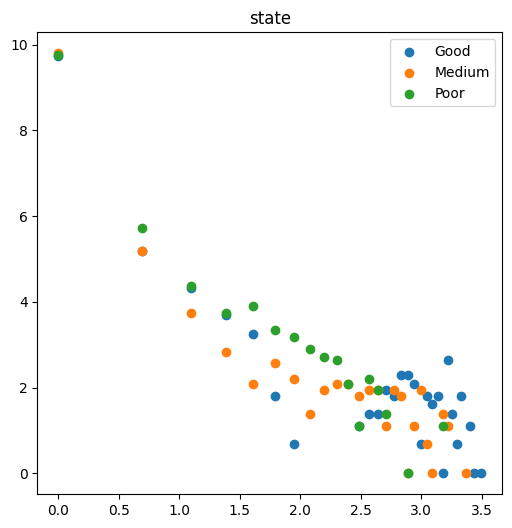

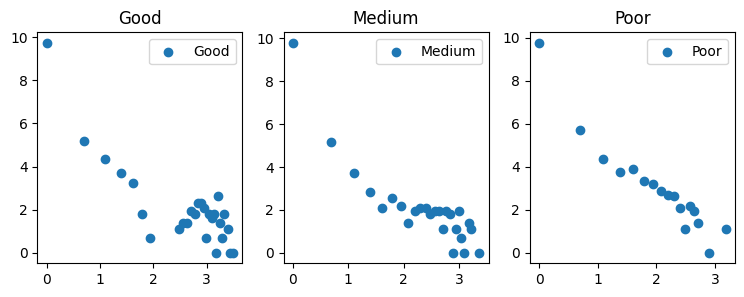

In [16]:

for key in keys:
    print("KEY: "+key)

    fig2,ax2 = plt.subplots(1,1,figsize=(6,6))

    fig, ax = plt.subplots(1,len(vault_uids), figsize=(len(vault_uids)*3,3))

    # fig2,ax2 = plt.subplots(1,1,figsize=(6,6))

    # for the joint
    for i,uid in enumerate(vault_uids):
        (counts, rewards) = counts_over_datasets[uid]
        vals2, counts2 = np.unique(counts[key],return_counts=True)

        ax[i].scatter(np.log(vals2),np.log(counts2),label=uid)
        ax[i].set_title(uid)
        ax[i].legend()

        plt.savefig(rel_dir+"/"+new_vault_name+"/"+key+"power_law.png")

        ax2.scatter(np.log(vals2),np.log(counts2),label=uid)
        ax2.set_title(key)
        ax2.legend()
    plt.show()

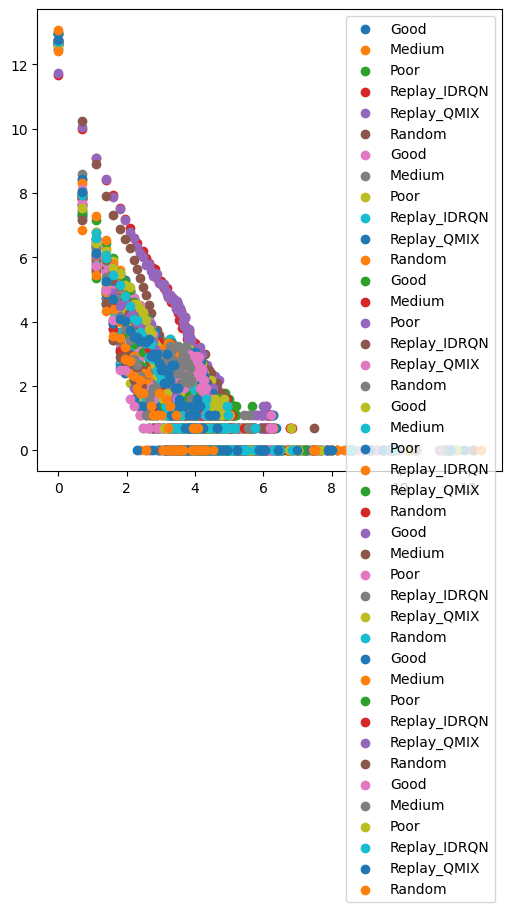

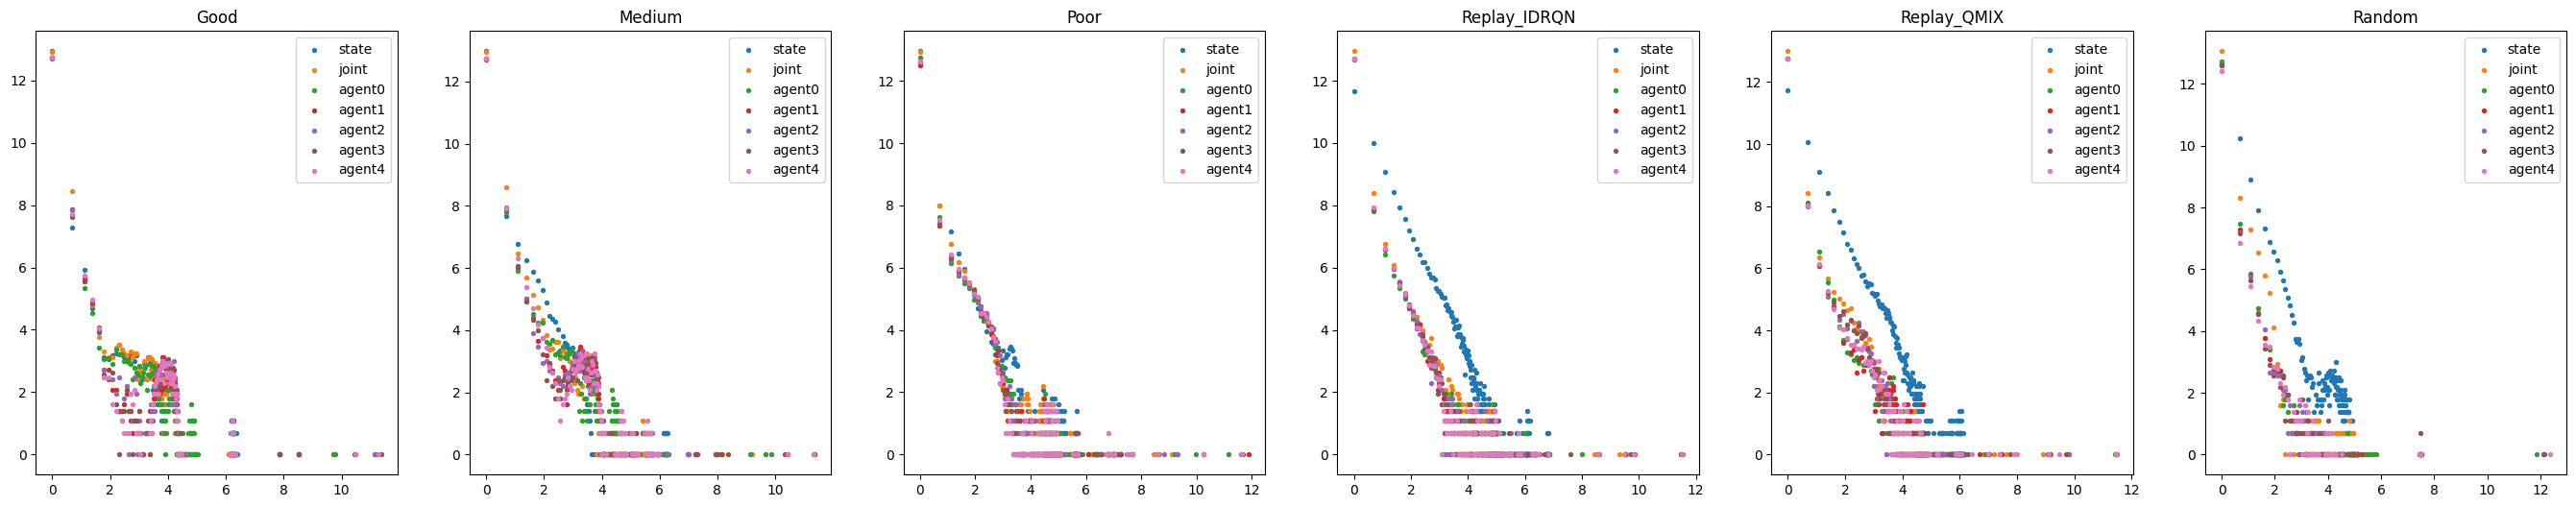

In [17]:


fig2,ax2 = plt.subplots(1,1,figsize=(6,6))

fig, ax = plt.subplots(1,6, figsize=(34,6))

for key in keys:

    # for the joint
    for i,uid in enumerate(uids):
        (vals,indices,counts, rewards) = counts_over_datasets[uid]
        vals2, counts2 = np.unique(counts[key],return_counts=True)

        ax[i].scatter(np.log(vals2),np.log(counts2),label=key,s=8)
        ax[i].legend()
        ax[i].set_title(uid)

        ax2.scatter(np.log(vals2),np.log(counts2),label=uid)
        ax2.legend()
plt.savefig(rel_dir+"/"+vault_name+"/"+key+"power_law_superimposed.png")
plt.show()